<a href="https://colab.research.google.com/github/josiahlin119/IMDB-Final-Project/blob/main/Imdb_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup

import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from tensorflow.keras import models
from tensorflow.keras import layers

sns.set_style("whitegrid")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

In [3]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josiah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
imdb_data=pd.read_csv('https://raw.githubusercontent.com/josiahlin119/IMDB-Final-Project/main/ReviewData/IMDB%20Dataset.csv')
print(imdb_data.shape)
imdb_data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [6]:
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [7]:


# Lets encode labels: each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
imdb_data['sentiment'] = label_encoder.fit_transform(imdb_data['sentiment'])
imdb_data.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


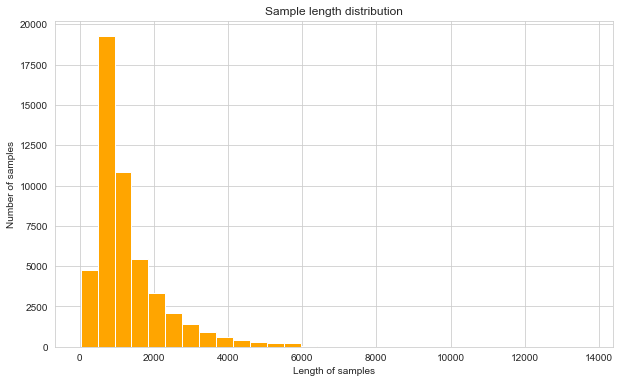

In [8]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist(x=[len(sample) for sample in list(imdb_data['review'])], bins=30,density=False,color='Orange')
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [9]:

tokenizer=ToktokTokenizer()
#filter out all stop words which do not contribute much to the learning
stopword_list = nltk.corpus.stopwords.words('english')


Remove irrelevent symbols

In [10]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]','',text)
def remove_special_characters(text, remove_digits=True):
  pattern=r'[^a-zA-Z0-9\s]'
  text=re.sub(pattern,'',text)
  return text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = remove_special_characters(text)
  return text
imdb_data['review']=imdb_data['review'].apply(denoise_text)


/Users/josiah/opt/anaconda3/envs/DL/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Word Stemming

In [11]:
def my_stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text
imdb_data['review']=imdb_data['review'].apply(my_stemmer)


Remove Stop Words

In [12]:
stop=set(stopwords.words('english'))
print(stop)

def remove_stopwords(text, is_lower_case=False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text= ' '.join(filtered_tokens)
  return filtered_text
imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)



{'for', 'was', 'd', 'and', 'while', 've', 'our', "didn't", 'through', "needn't", 'herself', 'these', 'only', 'doesn', 'if', 'so', 'were', 'just', 'itself', 'own', 'the', 'where', 'he', 'they', 'an', "couldn't", 'by', 'some', "doesn't", "that'll", 'mightn', 'my', 'who', 'i', "haven't", 'at', 'once', 'very', "mustn't", 'haven', 'this', 'in', 'each', 'during', 'up', 'll', 'until', 'should', 'himself', 'most', 'whom', 'about', "you're", 'have', "isn't", 'being', 'again', 'will', "weren't", 'be', 'can', 'both', 'all', 'don', 'further', "you'll", 'because', 'any', 'no', 'above', 'from', 'over', "wasn't", 'been', 'but', 'didn', 'how', 'shan', 'theirs', 'do', 'its', "she's", 'needn', 'm', 'having', "won't", "wouldn't", 'other', 'aren', 'yourselves', 'yourself', 'into', "hadn't", 'here', 'you', 'myself', 'or', 'between', 'below', 'isn', 'a', 'mustn', 'to', 'off', 'did', 'we', "you'd", "mightn't", 'has', 'she', 'ours', 'won', 'on', 'under', 'me', 'which', 'am', "it's", 'are', 'his', 'themselves'

In [13]:
# cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,2))
# cv_reviews_train=cv.fit_transform(train_reviews)
# cv_reviews_test=cv.transform(test_reviews)
# print('BOW_cv_train: ', cv_reviews_train.shape)
# print('BOW_cv_test:', cv_reviews_test.shape)
# all_ngrams = cv.get_feature_names()
# print(all_ngrams)
# num_ngrams = min(50, len(all_ngrams))

In [14]:
# #Tfidf vectorizer
# tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
# #transformed train reviews
# tv_reviews_train=tv.fit_transform(train_reviews)
# #transformed test reviews
# tv_reviews_test=tv.transform(test_reviews)
# print('Tfidf_train:',tv_reviews_train.shape)
# print('Tfidf_test:',tv_reviews_test.shape)



In [15]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


def select_best(transformed_texts,labels):
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
def ngram_vectorize(texts, labels,vectorizor_type):
    
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
        # 'stop_words': 'english'
    }
    # Learn Vocab from train texts and vectorize train and val sets
    
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    tfidf_transformed_texts = tfidf_vectorizer.fit_transform(texts)
    cv_vectorizer = CountVectorizer(**kwargs)
    cv_transformed_text=cv_vectorizer.fit_transform(texts)
    if vectorizor_type == 'tfidf':
        return select_best(tfidf_transformed_texts,labels)
    elif vectorizor_type == 'count':
        return select_best(cv_transformed_text,labels)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    
   
    
# Vectorize the data



tv_reviews = ngram_vectorize(imdb_data['review'],imdb_data['sentiment'],'tfidf')
cv_reviews = ngram_vectorize(imdb_data['review'],imdb_data['sentiment'],'count')


/Users/josiah/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1796: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "
/Users/josiah/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1796: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


In [16]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(imdb_data['review'])
tr_texts.shape

(50000, 181432)

Decide which vectorizer we are going to use...

Split both of cv and tv reviews

In [17]:

from sklearn.model_selection import train_test_split

cv_reviews = cv_reviews.toarray()
input_shape = cv_reviews.shape[1:]

tv_reviews = tv_reviews.toarray()
input_shape = tv_reviews.shape[1:]

y = (np.array(imdb_data['sentiment']))
#


In [18]:
cv_reviews_train, cv_reviews_test, cv_y_train, cv_y_test = train_test_split(cv_reviews, y, test_size=0.2, random_state=77)
tv_reviews_train, tv_reviews_test, tv_y_train, tv_y_test = train_test_split(tv_reviews,y, test_size=0.2, random_state=88)

print("shape of X_train", cv_reviews_train.shape)

cv_reviews_train.shape

shape of X_train (40000, 20000)


(40000, 20000)

In [19]:

loss_function = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

addition_metrics = ['accuracy']
number_of_epochs=100
verbosity_mode =True
validation_split = 0.2
#add a callback function to speed up the process 
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]


Deep Learning Model: Keras. The input data are transformed tokens insteaed of the original words

In [20]:
# print("type of cv_revie",type(cv_reviews_train))


model = keras.Sequential()
print(y.shape)
model.add(layers.Dropout(rate=0.2, input_shape=input_shape))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss=loss_function, metrics=addition_metrics)
model.summary()


# print(f'Test results - Loss: {test_results[0]} - Accuracy:{100*test_results[1]}')

(50000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Logistic Regression: Bag of words and Term Frequency-Inverse document Frequency


In [21]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [22]:
cv_history = model.fit(cv_reviews_train, cv_y_train,epochs=number_of_epochs, verbose=verbosity_mode,batch_size=128,validation_split=0.2,callbacks=callbacks)
cv_test_results = model.evaluate(cv_reviews_test, cv_y_test, verbose=False)
print(cv_test_results)

# Let's plot training and validation accuracy as well as loss.



Epoch 1/100
250/250 [==============================] - 4s 15ms/step - loss: 0.4040 - accuracy: 0.8289 - val_loss: 0.2449 - val_accuracy: 0.9057
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1945 - accuracy: 0.9272 - val_loss: 0.2354 - val_accuracy: 0.9066
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1442 - accuracy: 0.9452 - val_loss: 0.2327 - val_accuracy: 0.9084
Epoch 4/100
250/250 [==============================] - 3s 10ms/step - loss: 0.1187 - accuracy: 0.9558 - val_loss: 0.2423 - val_accuracy: 0.9128
Epoch 5/100
250/250 [==============================] - 3s 10ms/step - loss: 0.0932 - accuracy: 0.9640 - val_loss: 0.2466 - val_accuracy: 0.9131
Epoch 6/100
250/250 [==============================] - 3s 10ms/step - loss: 0.0784 - accuracy: 0.9717 - val_loss: 0.2516 - val_accuracy: 0.9116
Epoch 7/100
250/250 [==============================] - 3s 10ms/step - loss: 0.0761 - accuracy: 0.9734 - val_loss: 0.2556 - val_accuracy:

[0.9057499766349792, 0.906624972820282, 0.9083750247955322, 0.9127500057220459, 0.9131249785423279, 0.9116250276565552, 0.9138749837875366, 0.9118750095367432]


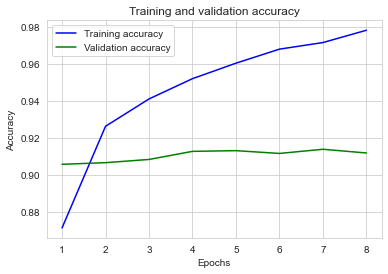

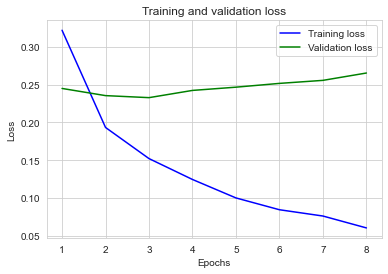

In [23]:
print(cv_history.history['val_accuracy'])
plot_history(cv_history)

In [24]:
tv_history = model.fit(tv_reviews_train, tv_y_train,epochs=number_of_epochs, verbose=verbosity_mode,batch_size=128,validation_split=0.2,callbacks=callbacks)

tv_test_results = model.evaluate(tv_reviews_test, tv_y_test, verbose=False)
print(tv_test_results)


Epoch 1/100
250/250 [==============================] - 4s 14ms/step - loss: 0.4053 - accuracy: 0.8131 - val_loss: 0.2952 - val_accuracy: 0.8825
Epoch 2/100
250/250 [==============================] - 3s 10ms/step - loss: 0.2747 - accuracy: 0.8873 - val_loss: 0.2533 - val_accuracy: 0.8991
Epoch 3/100
250/250 [==============================] - 3s 10ms/step - loss: 0.2325 - accuracy: 0.9066 - val_loss: 0.2347 - val_accuracy: 0.9064
Epoch 4/100
250/250 [==============================] - 3s 10ms/step - loss: 0.2067 - accuracy: 0.9191 - val_loss: 0.2254 - val_accuracy: 0.9091
Epoch 5/100
250/250 [==============================] - 2s 10ms/step - loss: 0.1862 - accuracy: 0.9282 - val_loss: 0.2174 - val_accuracy: 0.9120
Epoch 6/100
250/250 [==============================] - 3s 10ms/step - loss: 0.1659 - accuracy: 0.9363 - val_loss: 0.2137 - val_accuracy: 0.9145
Epoch 7/100
250/250 [==============================] - 2s 10ms/step - loss: 0.1533 - accuracy: 0.9405 - val_loss: 0.2121 - val_accuracy:

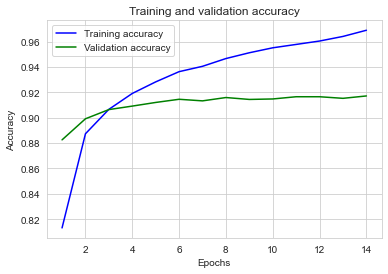

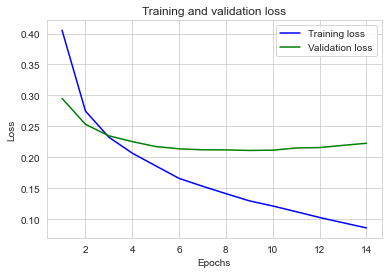

In [25]:

plot_history(tv_history)

In [26]:
# lr = LogisticRegression(penalty='l2',max_iter=200,n_jobs=-1, verbose=1, random_state=77)
# logistic_bow= lr.fit(cv_reviews_train, cv_y_train)
# print(logistic_bow)
# logistic_tfidf=lr.fit(tv_reviews_train,tv_y_train)
# print(logistic_tfidf)



In [27]:
# logistic_bow_pred = lr.predict(cv_reviews_test)
# print(logistic_bow_pred)
# logistic_tfidf_pred=lr.predict(tv_reviews_test)
# print(logistic_tfidf_pred)


In [28]:
# lr_bow_report=classification_report(cv_y_test,logistic_bow_pred, target_names=['Positive','Negative'])
# print("Count")
# print(lr_bow_report)
# lr_tfidf_report=classification_report(tv_y_test, logistic_tfidf_pred, target_names=['Positive','Negative'])
# print("tfidf")
# print(lr_tfidf_report)

In [29]:
# #cv
# lr_bow_report=classification_report(cv_y_test,logistic_bow_pred, target_names=['Positive','Negative'])
# print(lr_bow_report)
# #tfidf
# lr_tfidf_report=classification_report(tv_y_test, logistic_tfidf_pred, target_names=['Positive', 'Negative'])
# print(lr_tfidf_report)


In [30]:
svm=SGDClassifier(loss='hinge', max_iter=1000, random_state=77)
svm_bow=svm.fit(cv_reviews_train, cv_y_train)
print(svm_bow)
svm_tfidf=svm.fit(tv_reviews_train, tv_y_train)
print(svm_tfidf)





SGDClassifier(random_state=77)
SGDClassifier(random_state=77)


In [31]:

svm_bow_predict=svm.predict(cv_reviews_test)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_reviews_test)
print(svm_tfidf_predict)

svm_bow_report=classification_report(cv_y_test, svm_bow_predict, target_names=['Positive','Negative'])
print(svm_bow_report)
svm_tfidf_report=classification_report(tv_y_test, svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)


[0 1 0 ... 1 1 0]
[1 0 0 ... 1 0 0]
              precision    recall  f1-score   support

    Positive       0.57      0.56      0.56      5051
    Negative       0.56      0.56      0.56      4949

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      4973
    Negative       0.89      0.90      0.90      5027

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [32]:
svm_bow_score=accuracy_score(cv_y_test,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(tv_y_test,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5619
svm_tfidf_score : 0.8951


In [33]:
#Classification report for bag of words 
svm_bow_report=classification_report(cv_y_test,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(tv_y_test,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.57      0.56      0.56      5051
    Negative       0.56      0.56      0.56      4949

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      4973
    Negative       0.89      0.90      0.90      5027

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Multinomial Naive Bayes

In [34]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_reviews_train,cv_y_train)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_reviews_train,tv_y_train)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [35]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_reviews_test)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_reviews_test)
print(mnb_tfidf_predict)

[1 1 0 ... 1 1 0]
[1 0 0 ... 1 1 0]


In [36]:
mnb_bow_report=classification_report(cv_y_test,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(tv_y_test,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.58      0.55      0.57      5051
    Negative       0.56      0.59      0.58      4949

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

              precision    recall  f1-score   support

    Positive       0.91      0.89      0.90      4973
    Negative       0.89      0.92      0.91      5027

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Use Word Cloud to show the most popular positive and negative reviews

In [37]:
mnb_bow_score=accuracy_score(cv_y_test,mnb_bow_predict)
print("mnb_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(tv_y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",svm_tfidf_score)

mnb_bow_score : 0.5619
mnb_tfidf_score : 0.8951


In [38]:
plt.figure(figsize=(10,10))
positive_text=cv_reviews_train[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show


TypeError: cannot use a string pattern on a bytes-like object

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
negative_text=cv_reviews_train[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show